# Proyecto 4: Faces in The Wild

**Integrantes**:
- Lucas Carranza
- David Herencia
- Kalos Lazo
- Lenin Chavez

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

import torchvision
from torchvision import transforms, datasets

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda:0


## Exploración del Dataset

In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Split the 'image1_image2' column into two columns
train_df[['image1', 'image2']] = train_df['image1_image2'].str.split('_', expand=True)
test_df[['image1', 'image2']] = test_df['image1_image2'].str.split('_', expand=True)

# Drop the original 'image1_image2' column
train_df.drop(columns=['image1_image2'], inplace=True)
test_df.drop(columns=['image1_image2'], inplace=True)

# Reorder cols
train_df = train_df[['image1', 'image2', 'label']]

# Convert label image to number
# diff = 0
# same = 1
train_df['label'] = pd.factorize(train_df['label'])[0]

train_df.head()

,image1,image2,label
0,1485,4047,0
1,5335,6055,1
2,10796,3696,1
3,11991,6672,1
4,7003,2539,1


In [5]:
# Helper functions to load images from dataset and plot them
def load_img(img_id):
    path = f"images/{img_id}.png"
    return Image.open(path)

def plot_imgs(imgs, size=3):
    img_number = imgs.shape[0]
    rows = cols = math.ceil(np.sqrt(img_number))
    fig = plt.figure(figsize=(rows*size, cols*size))
    for i in range(img_number):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

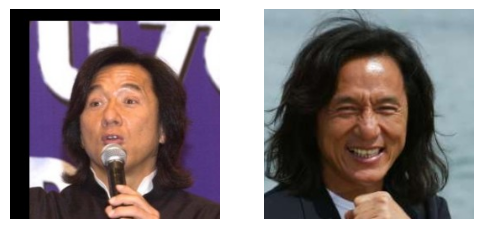

(250, 250, 3)

In [6]:
# Example on how to load and plot images
im1 = load_img(train_df['image1'][1347])
im2 = load_img(train_df['image2'][1347])
plot_imgs(np.array([im1, im2]))

np.array(im1).shape # Imagenes de 250x250 en formato RGB

## Modelo 1: Siamese CNN

### Data Loader for Siamese CNN

Debido a que la Red Neuronal Convolucional requiere de 2 entradas de imagenes para validar si corresponden a la misma persona o no, requerimos de un Dataset personalizado, donde la entrada consista en 2 imagenes y un label. Es por esto que creamos la clase `TwoImageDataset` a partir de la clase `Dataset` de pytorch, la cual puede obtener todos los pares de imágenes y cargarlos de dos en dos junto con el label que nos indican si son la misma persona o no.

In [7]:
class TwoImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_id = self.df.iloc[idx, 0]
        img2_id = self.df.iloc[idx, 1]
        label = self.df.iloc[idx, 2]

        img1 = load_img(img1_id)
        img2 = load_img(img2_id)
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [8]:
batch_size = 8
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Randomly rotate the image by 10 degrees
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with Image stats
])

# Train-Test split
from sklearn.model_selection import train_test_split
train_subset_df, val_subset_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Initializing custom datasets
train_dataset = TwoImageDataset(train_subset_df, transform=transform)
val_dataset = TwoImageDataset(val_subset_df, transform=transform)

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example to check the dataloader
for img1, img2, label in train_dataloader:
    print(img1.shape, img2.shape, label.shape)
    print(label)
    break

torch.Size([8, 3, 250, 250]) torch.Size([8, 3, 250, 250]) torch.Size([8])
tensor([1., 0., 1., 1., 0., 0., 1., 0.])


In [22]:
class SiameseCNN(nn.Module):
    def __init__(self):
        super(SiameseCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), #250
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #125
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2), #125
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #62

            nn.Conv2d(64, 128, kernel_size=7, padding=3), #62
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) #31
        )

        self.fc = nn.Sequential(
            nn.Linear(128*31*31 * 2, 512),
            nn.Dropout(0.25),
            nn.ReLU(),
            
            nn.Linear(512, 1)
        )

    def forward_once(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, img1, img2):
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)
        # print(out1.shape)
        
        concat = torch.cat((out1, out2), 1)
        # print(concat.shape)
        
        output = self.fc(concat)
        output = torch.flatten(output)
        # print(output.shape)
        return output

In [17]:
def train(model, train_loader, loss_fn, optimizer, num_epochs):
    total_step = len(train_loader)
    list_loss = []
    for epoch in range(num_epochs):
        model.train()
        for i, (images1, images2, labels) in enumerate(train_loader):
            images1 = images1.to(device)
            images2 = images2.to(device)
            labels = labels.to(device)

            output = model(images1, images2)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            list_loss.append(loss.item())
            i += 1

            if (i + 1) % 5 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    print('Finished Training Trainset')
    return list_loss

In [23]:
epochs = 3
learning_rate = 0.001
model = SiameseCNN().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/3], Step [5/220], Loss: 195.68141174316406
Epoch [1/3], Step [10/220], Loss: 51.14365768432617
Epoch [1/3], Step [15/220], Loss: 56.74774932861328
Epoch [1/3], Step [20/220], Loss: 14.87729263305664
Epoch [1/3], Step [25/220], Loss: 22.482099533081055
Epoch [1/3], Step [30/220], Loss: 7.508899688720703
Epoch [1/3], Step [35/220], Loss: 10.924711227416992
Epoch [1/3], Step [40/220], Loss: 12.027517318725586
Epoch [1/3], Step [45/220], Loss: 30.310239791870117
Epoch [1/3], Step [50/220], Loss: 4.8827667236328125
Epoch [1/3], Step [55/220], Loss: 4.289494037628174
Epoch [1/3], Step [60/220], Loss: 5.199997901916504
Epoch [1/3], Step [65/220], Loss: 6.183323860168457
Epoch [1/3], Step [70/220], Loss: 4.931576728820801
Epoch [1/3], Step [75/220], Loss: 0.6009395122528076
Epoch [1/3], Step [80/220], Loss: 5.786802291870117
Epoch [1/3], Step [85/220], Loss: 7.006383895874023
Epoch [1/3], Step [90/220], Loss: 1.6097629070281982
Epoch [1/3], Step [95/220], Loss: 3.816824197769165
Epoch

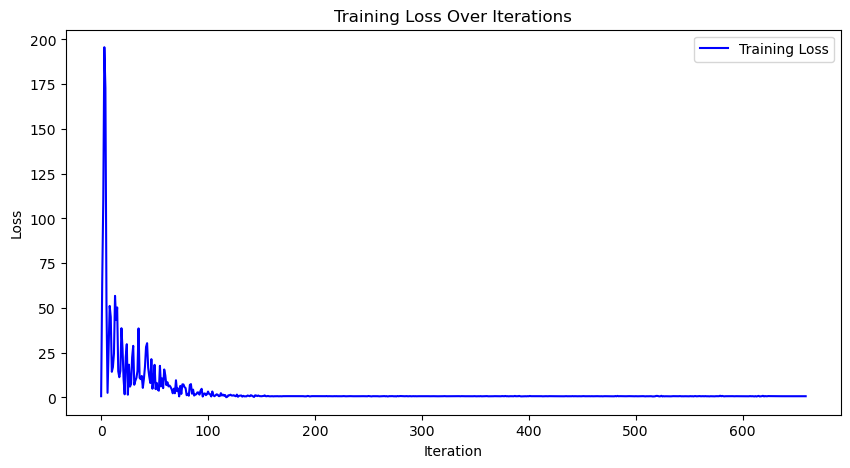

In [24]:
torch.cuda.empty_cache()
list_loss = train(model, train_dataloader, loss_fn, optimizer, epochs)

# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(list_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

## Modelo 2: ??

## Experimentación

## Testing